**Toy Navigational Model**

*Author*: Shoubhik Banerjee\
*Date*: 01-04-2026

This notebook implements a simple 1D navigational model in which agents move from a start site at (0, 1) toward a home site at (0, 0). Two distinct navigation conditions are simulated: first, where agents fly as stable pairs developing a shared memorized route (CM) and second where individuals are flown as shuffled pairs with a new partner (CI). At each time step, a pair can occupy one of four information states: 00 — least informed state (neither agent has information of the route), 10, 01 — one agent is informed or 11 — fully informed (both agents have complete information of the route). Based on this formulation, stable pairs (CM), always occupy informed states (10 or 01), assuming that at any given moment one agent effectively leads or has knowledge of the landscape. Shuffled pairs (CI), in contrast, occupy the least informed state (00) in 25% of steps, when neither agent has usable information about the route. The simulation proceeds as follows:

Agents navigate by maintaining a noisy estimate of the bearing to home (defined as the angle between their current position and the home site). The magnitude of this noise scales with:

1. The current distance from home, $D_t$

2. The information state of the pair parameterized by: $\sigma_m$ — noise for informed states and $\sigma_l$ — noise for least informed states with $\sigma_l > \sigma_m$.

We quantify the pair's performance using route efficiency, defined as the ratio of the beeline distance (here 1 unit) and the total distance traveled by the pair. Further sections in the code checks for convergence of mean route efficiency with: Number of simulation replicates and Step size for a given $\sigma$ pair. We also perform a parameter scan across values of $\sigma_m$ and $\sigma_l$ with $\sigma_l > \sigma_m$. Further details of the model assumptions, results, and interpretation are provided in the main text and accompanying figures.

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from numba import njit
from joblib import Parallel, delayed
import matplotlib as mpl

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['svg.image_inline'] = True


In [2]:
#----------------------------------------------------------------------------------------------
# Simulation code considering fixed y step downwards and just adding distance based sigma scaling
# Faster version using Numba
#----------------------------------------------------------------------------------------------

@njit
def simulate_route_efficiency(
    step_size,
    sigma_l,
    sigma_m,
    P_less,
    base_seed = 123
):  
    np.random.seed(base_seed)
    #start position
    x = 0.0
    y = 1.0

    #total distance counter
    total_dist = 0.0

    #total number of steps
    n_steps = int(1.0 / step_size) 

    for _ in range(n_steps):

        #bearing to home from current point
        bearing = np.arctan2(x, y)

        #choose a sigma regime
        if np.random.random() < P_less:
            sigma_choice = sigma_l
        else:
            sigma_choice = sigma_m

        #find distance to home from current location and scale by it
        d = np.sqrt(x*x + y*y)
        sigma_scaled = sigma_choice * d

        #add the scaled sigma noise to home bearing
        noisy = np.random.normal(bearing, sigma_scaled)

        #go step size step downwards
        y_new = y - step_size

        #calculate tan val
        tan_val = np.tan(noisy)
        if abs(tan_val) < 1e-6:
            dx = 0.0
        else:
            dx = -step_size * tan_val

        #update x drift
        x_new = x + dx

        #find euclidean distance and add it to cummulative counter
        total_dist += np.sqrt(dx*dx + step_size*step_size)

        #update x and y with new location
        x, y = x_new, y_new

    #return the route efficiency
    return 1.0 / total_dist


In [3]:
# ---------------------------------------------------------
# Generate replicate data, core functions
# ---------------------------------------------------------

@njit(parallel=True)

#runs a specific set of replicate and stores their efficiency
def run_replicates(
    n_reps,
    step_size,
    sigma_l,
    sigma_m,
    P_less,
    master_seed=123
):
    
    out = np.empty(n_reps)
    for i in range(n_reps):
        seed_i = master_seed + i #this is kind of a proxy to the seed where I create a master seed and the sequence of seeds originating from this master seed are replicable
        out[i] = simulate_route_efficiency(
            step_size, sigma_l, sigma_m, P_less=P_less, base_seed=seed_i
        )
    return out

#evaluates sigma m and l pairs and returns the mean efficeicny and difference
def evaluate_pair(args):
    sigma_l, sigma_m, n_reps, step_size = args

    if sigma_m >= sigma_l:
        return None

    re_p0 = run_replicates(
        n_reps, step_size, sigma_l, sigma_m, P_less = 0.0
    )
    re_p025 = run_replicates(
        n_reps, step_size, sigma_l, sigma_m, P_less= 0.25
    )

    return (
        sigma_l,
        sigma_m,
        re_p0.mean(),
        re_p025.mean(),
        re_p0.mean() - re_p025.mean()
    )

/home/shoubhikb/miniconda3/envs/yolo/lib/python3.11/site-packages/numba/core/typed_passes.py:338: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../tmp/ipykernel_2055912/437114304.py", line 5:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/tmp/ipykernel_2055912/1059623247.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


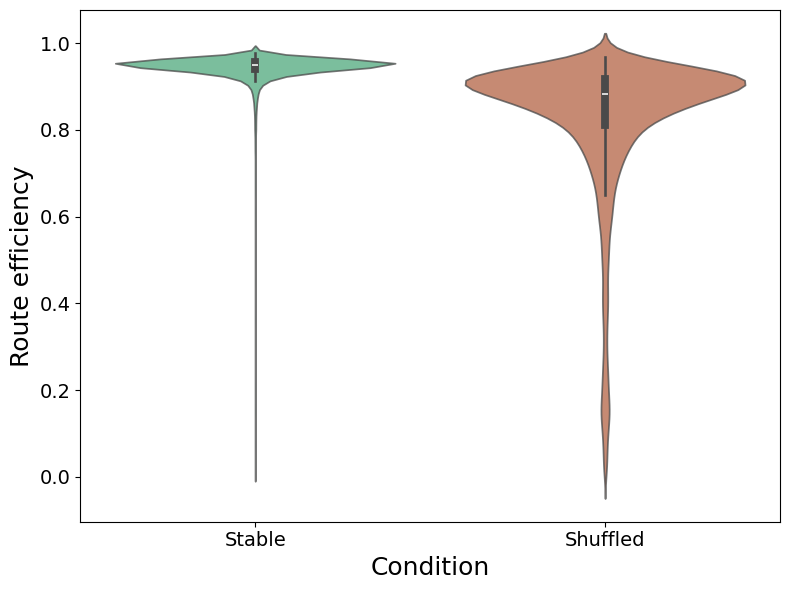

In [4]:

re_stable = run_replicates(
    n_reps=10000,
    step_size=0.01,
    sigma_l=1.0,
    sigma_m=0.5,
    P_less=0.0
)

re_shuffled = run_replicates(
    n_reps=10000,
    step_size=0.01,
    sigma_l=1.0,
    sigma_m=0.5,
    P_less=0.25
)

df_all = pd.DataFrame({
    "route_efficiency": np.concatenate([re_stable, re_shuffled]),
    "condition": (["Stable"] * len(re_stable)) + (["Shuffled"] * len(re_shuffled))
})


plt.figure(figsize=(8, 6))

sns.violinplot(
    data=df_all,
    x="condition",
    y="route_efficiency",
    #cut=0,
    inner="box",
    alpha=0.75,
    palette=["#40b77e8c", "#c55b328c"]
)

plt.xlabel("Condition", fontsize=18)
plt.ylabel("Route efficiency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("../2_plots/route_eff.svg", format="svg")
plt.show()

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
/home/shoubhikb/miniconda3/envs/yolo/lib/python3.11/site-packages/numba/core/typed_passes.py:338: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../tmp/ipykernel_2055912/437114304.py", line 5:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/home/shoubhikb/miniconda3/envs/yolo/lib/python3.11/site-packages/numba/core/typed_passes.py:338: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../..

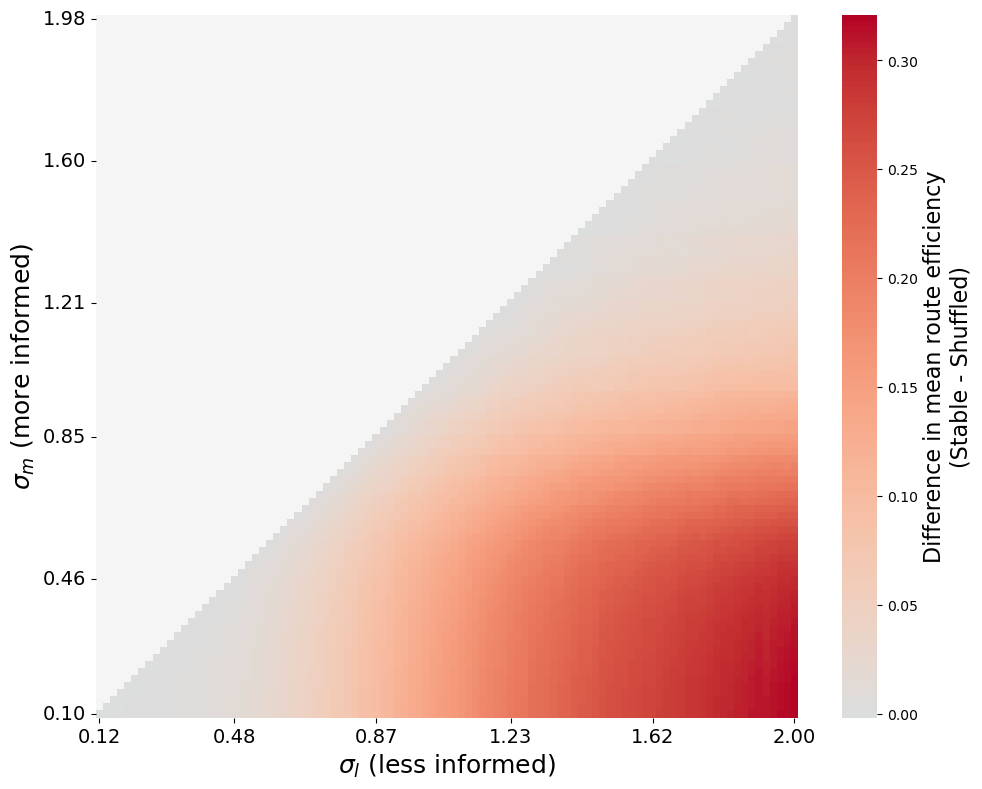

In [5]:
# ---------------------------------------------------------
# Parameter Scan across sigma less and more
# ---------------------------------------------------------
def run_param_scan_parallel(
    sigma_l_values,
    sigma_m_values,
    n_reps=10000,
    step_size=0.1,
    n_jobs=48
):
    tasks = [
        (sl, sm, n_reps, step_size)
        for sl in sigma_l_values
        for sm in sigma_m_values
        if sm < sl
    ]

    results = Parallel(
        n_jobs=n_jobs,
        backend="loky",      
        verbose=10
    )(delayed(evaluate_pair)(t) for t in tasks)

    results = [r for r in results if r is not None]

    return pd.DataFrame(
        results,
        columns=[
            "sigma_less",
            "sigma_more",
            "mean_RE_P0",
            "mean_RE_P025",
            "difference"
        ]
    )

#Main code to run the param scan function
sigma_l_values = np.linspace(0.1, 2.0, 100)

sigma_m_values = np.linspace(0.1, 2.0, 100)

df_scan = run_param_scan_parallel(
    sigma_l_values,
    sigma_m_values,
    step_size=0.01,
    n_reps=10000,
    n_jobs=40
)

# Save the dataframe
df_scan.to_csv("../1_Data/param_scan_results.csv", index=False) 

#create a heatmap
heatmap_df = df_scan.pivot(
    index="sigma_more",
    columns="sigma_less",
    values="difference"
)

mask = heatmap_df.isna()

# Custom colormap with grey for NaN
cmap = sns.color_palette("coolwarm", as_cmap=True)
cmap.set_bad(color="#f5f5f5")

plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    heatmap_df,
    mask=mask,
    cmap=cmap,
    center=0,
    annot=False,
    square=True
)
# Reverse y-axis
ax.invert_yaxis()

# ----------------------------
# UNIFORM TICKING LOGIC
# ----------------------------
num_ticks = 6  # start, end, and 4 evenly spaced ticks


x_vals = heatmap_df.columns.values
y_vals = heatmap_df.index.values

x_idx = np.linspace(0, len(x_vals) - 1, num_ticks).astype(int)
y_idx = np.linspace(0, len(y_vals) - 1, num_ticks).astype(int)

ax.set_xticks(x_idx + 0.5)
ax.set_yticks(y_idx + 0.5)

ax.set_xticklabels([f"{x_vals[i]:.2f}" for i in x_idx], rotation = 0, fontsize=14)
ax.set_yticklabels([f"{y_vals[i]:.2f}" for i in y_idx], fontsize=14)

# Labels
plt.xlabel(r"$\sigma_{l}$ (less informed)", fontsize=18)
plt.ylabel(r"$\sigma_{m}$ (more informed)", fontsize=18)


# Colorbar font sizes
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("Difference in mean route efficiency\n(Stable - Shuffled)",
                   fontsize=16, ha="center")

cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
#plt.savefig("../2_plots/param_scan.svg")
plt.show()


In [6]:
# ---------------------------------------------------------
# check step size influence using a step size scan
# ---------------------------------------------------------

def evaluate_step_size(args):
    sigma_l, sigma_m, step_size, n_trials = args

    if sigma_m >= sigma_l:
        return None

    re_p0 = run_replicates(
        n_trials, step_size, sigma_l, sigma_m, P_less = 0.0
    )
    re_p025 = run_replicates(
        n_trials, step_size, sigma_l, sigma_m, P_less = 0.25
    )

    mean_p0 = re_p0.mean()
    mean_p025 = re_p025.mean()

    sd_p0 = re_p0.std(ddof=1)
    sd_p025 = re_p025.std(ddof=1)

    return {
        "sigma_less": sigma_l,
        "sigma_more": sigma_m,
        "step_size": step_size,
        "n_trial": n_trials,

        "mean_RE_P0": mean_p0,
        "sd_RE_P0": sd_p0,
        "ci_low_RE_P0": mean_p0 - 1.96 * sd_p0 / np.sqrt(n_trials),
        "ci_high_RE_P0": mean_p0 + 1.96 * sd_p0 / np.sqrt(n_trials),

        "mean_RE_P025": mean_p025,
        "sd_RE_P025": sd_p025,
        "ci_low_RE_P025": mean_p025 - 1.96 * sd_p025 / np.sqrt(n_trials),
        "ci_high_RE_P025": mean_p025 + 1.96 * sd_p025 / np.sqrt(n_trials),

        "difference": mean_p0 - mean_p025
    }

def run_step_size_scan_parallel(
    sigma_l_values,
    sigma_m_values,
    step_size_list,
    n_trials=10000,
    n_jobs=48
):
    tasks = []

    for step_size in step_size_list:
        for sl in sigma_l_values:
            for sm in sigma_m_values:
                if sm < sl:
                    tasks.append((sl, sm, step_size, n_trials))

    results = Parallel(
        n_jobs=n_jobs,
        backend="loky",
        verbose=10
    )(delayed(evaluate_step_size)(t) for t in tasks)

    return pd.DataFrame([r for r in results if r is not None])

#main code for running step size scan and checking mean route efficiency for conditions
sigma_l_values = np.linspace(0.1, 2.0, 4)
sigma_m_values = np.linspace(0.1, 2.0, 4)

step_size_list = np.array([0.1, 0.01, 0.001, 0.0001])

trial_data_params = run_step_size_scan_parallel(
    sigma_l_values=sigma_l_values,
    sigma_m_values=sigma_m_values,
    step_size_list=step_size_list,
    n_trials=10000,
    n_jobs=40
)


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=40)]: Batch computation too fast (0.0499272346496582s.) Setting batch_size=2.
[Parallel(n_jobs=40)]: Done   2 out of  24 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=40)]: Done   5 out of  24 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=40)]: Done   8 out of  24 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=40)]: Done  11 out of  24 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=40)]: Done  14 out of  24 | elapsed:    1.8s remaining:    1.3s
[Parallel(n_jobs=40)]: Done  17 out of  24 | elapsed:    2.0s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  20 out of  24 | elapsed:   16.4s remaining:    3.3s
[Parallel(n_jobs=40)]: Done  24 out of  24 | elapsed:   18.5s finished


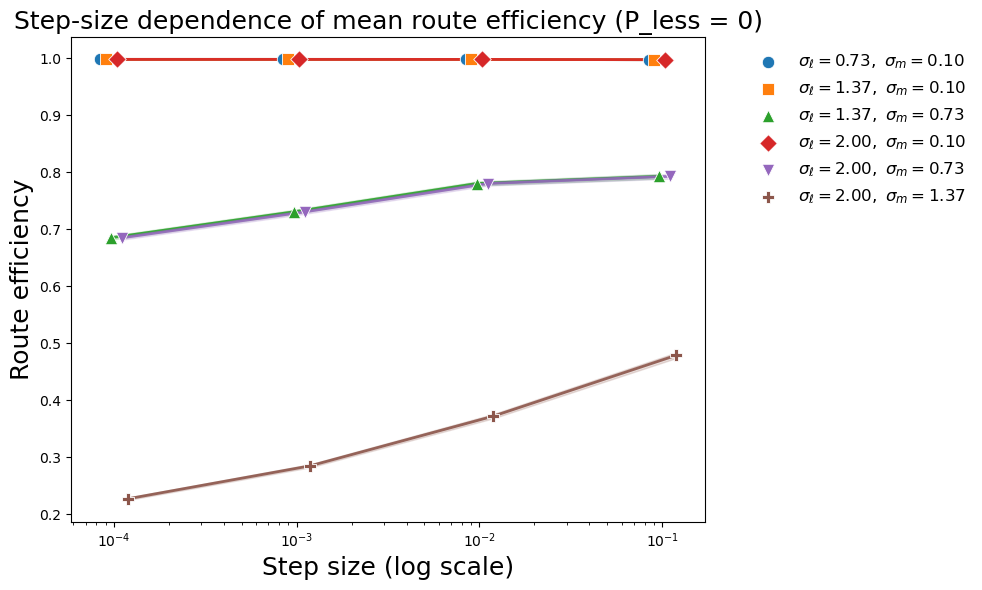

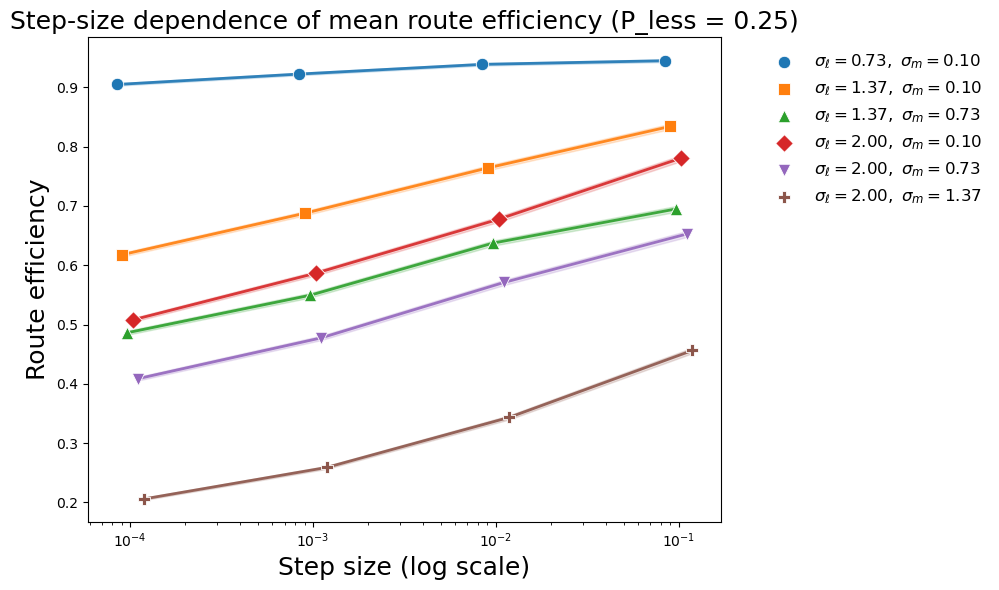

In [8]:
#Plot the step size vs mean route efficeincy 
def plot_step_size_by_sigma(
    df,
    y_mean_col,
    y_low_col,
    y_high_col,
    title,
    ylabel,
    outfile
):
    markers = ["o", "s", "^", "D", "v", "P"]

    groups = list(df.groupby(["sigma_less", "sigma_more"]))
    groups.sort(key=lambda g: (g[0][0], g[0][1]))

    plt.figure(figsize=(10, 6))

    # log-space jitter strength (≈ ±7% per group)
    log_jitter = 0.03

    n_groups = len(groups)

    for i, ((s_less, s_more), sub) in enumerate(groups):
        sub = sub.sort_values("step_size")

        marker = markers[i % len(markers)]
        color = f"C{i % 10}"

        # deterministic log-space offset
        offset = (i - (n_groups - 1) / 2) * log_jitter

        x = sub["step_size"].values
        x_jittered = x * (10 ** offset)

        label = rf"$\sigma_{{\ell}} = {s_less:.2f},\ \sigma_{{m}} = {s_more:.2f}$"

        # line
        plt.plot(
            x_jittered,
            sub[y_mean_col].values,
            linewidth=2,
            color=color,
            alpha=0.9,
            zorder=2
        )

        # points
        plt.scatter(
            x_jittered,
            sub[y_mean_col].values,
            marker=marker,
            s=80,
            color=color,
            edgecolor="white",
            linewidth=0.6,
            label=label,
            zorder=3
        )

        # confidence interval band
        plt.fill_between(
            x_jittered,
            sub[y_low_col].values,
            sub[y_high_col].values,
            color=color,
            alpha=0.18,
            zorder=1
        )

    plt.xscale("log")
    plt.xlabel("Step size (log scale)", fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=18)

    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=False,
        fontsize=12
    )

    plt.tight_layout()
    plt.savefig(outfile, format="svg")
    plt.show()
    plt.close()

plot_step_size_by_sigma(
    df=trial_data_params,
    y_mean_col="mean_RE_P0",
    y_low_col="ci_low_RE_P0",
    y_high_col="ci_high_RE_P0",
    title="Step-size dependence of mean route efficiency (P_less = 0)",
    ylabel="Route efficiency",
    outfile="../2_Plots/step_size_scan_stable.svg"
)

plot_step_size_by_sigma(
    df=trial_data_params,
    y_mean_col="mean_RE_P025",
    y_low_col="ci_low_RE_P025",
    y_high_col="ci_high_RE_P025",
    title="Step-size dependence of mean route efficiency (P_less = 0.25)",
    ylabel="Route efficiency",
    outfile="../2_Plots/step_size_scan_shuffled.svg"
)


In [9]:
# ---------------------------------------------------------
# Number of trials for stability
# ---------------------------------------------------------

def evaluate_trial_point(args):
    sigma_l, sigma_m, n_trial, step_size = args

    if sigma_m >= sigma_l:
        return None

    re_p0 = run_replicates(
        n_trial,
        step_size,
        sigma_l,
        sigma_m,
        0.0
    )

    re_p025 = run_replicates(
        n_trial,
        step_size,
        sigma_l,
        sigma_m,
        0.25
    )

    mean_p0 = re_p0.mean()
    mean_p025 = re_p025.mean()

    sd_p0 = re_p0.std(ddof=1)
    sd_p025 = re_p025.std(ddof=1)

    return {
        "sigma_less": sigma_l,
        "sigma_more": sigma_m,
        "n_trial": n_trial,

        "mean_RE_P0": mean_p0,
        "sd_RE_P0": sd_p0,
        "ci_low_RE_P0": mean_p0 - 1.96 * sd_p0 / np.sqrt(n_trial),
        "ci_high_RE_P0": mean_p0 + 1.96 * sd_p0 / np.sqrt(n_trial),

        "mean_RE_P025": mean_p025,
        "sd_RE_P025": sd_p025,
        "ci_low_RE_P025": mean_p025 - 1.96 * sd_p025 / np.sqrt(n_trial),
        "ci_high_RE_P025": mean_p025 + 1.96 * sd_p025 / np.sqrt(n_trial),

        "difference": mean_p0 - mean_p025
    }


def run_trial_scan_parallel(
    sigma_l_values,
    sigma_m_values,
    n_reps_list,
    step_size=0.01,
    n_jobs=40
):
    tasks = []
    for n_trial in n_reps_list:
        for sl in sigma_l_values:
            for sm in sigma_m_values:
                if sm < sl:
                    tasks.append((sl, sm, n_trial, step_size))

    results = Parallel(
        n_jobs=n_jobs,
        backend="loky",
        verbose=10
    )(delayed(evaluate_trial_point)(t) for t in tasks)

    return pd.DataFrame([r for r in results if r is not None])

sigma_l_values = np.linspace(0.1, 2.0, 4)
sigma_m_values = np.linspace(0.1, 2.0, 4)

n_reps = np.array([10, 100, 1000, 10000])

trial_data_reps = run_trial_scan_parallel(
    sigma_l_values=sigma_l_values,
    sigma_m_values=sigma_m_values,
    n_reps_list=n_reps,
    step_size=0.01,
    n_jobs=40
)


[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=40)]: Batch computation too fast (0.01008296012878418s.) Setting batch_size=2.
[Parallel(n_jobs=40)]: Done   2 out of  24 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=40)]: Done   5 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   8 out of  24 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=40)]: Done  11 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  14 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  17 out of  24 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  20 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  24 out of  24 | elapsed:    0.2s finished


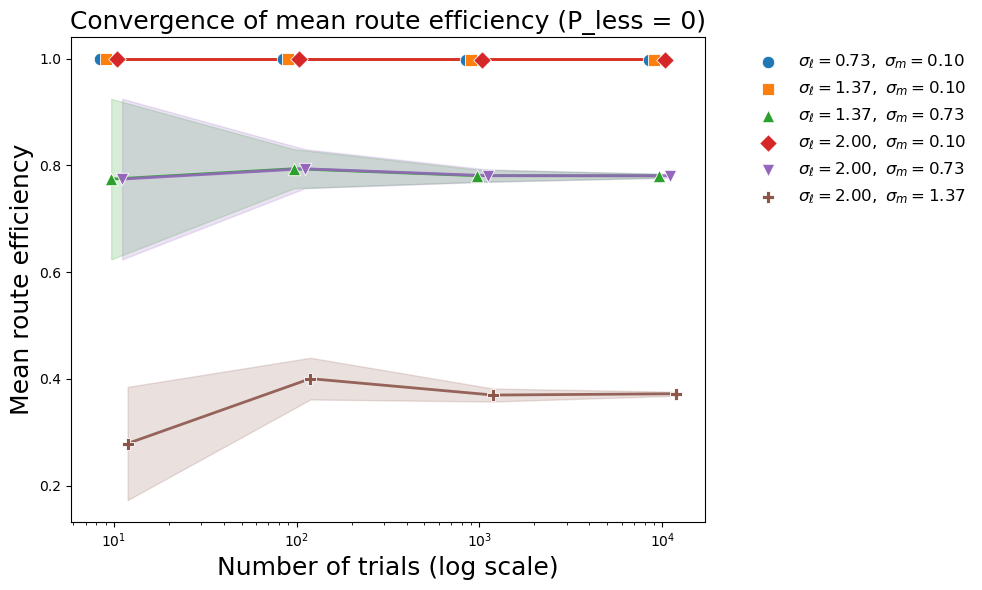

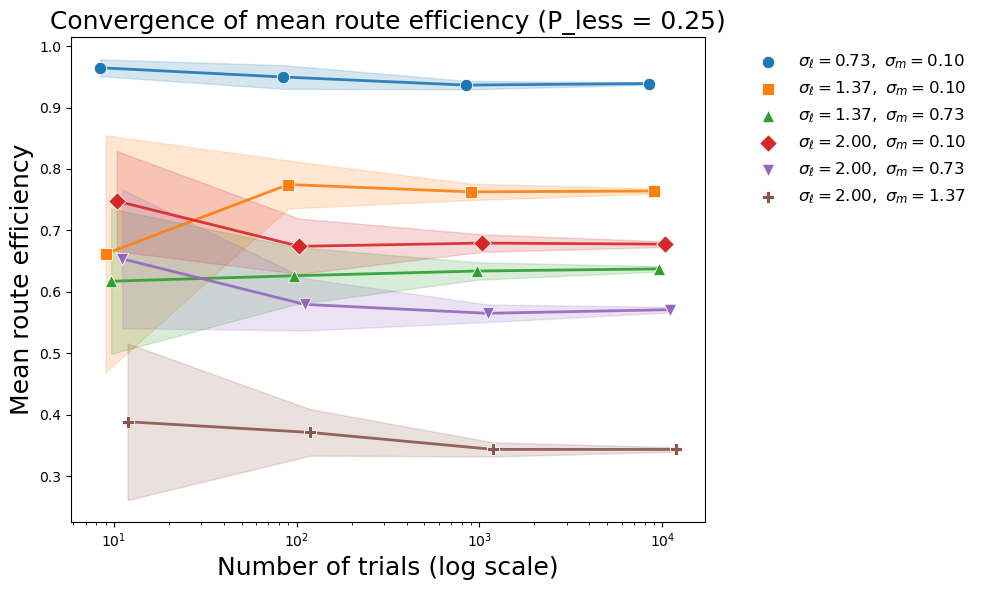

In [12]:
#plot trial stability
def plot_ci_lines_by_sigma(
    df,
    y_mean_col,
    y_low_col,
    y_high_col,
    title,
    outfile,
    ylabel="Mean route efficiency"
):
    markers = ["o", "s", "^", "D", "v", "P"]

    # Ensure stable ordering of σ-pairs
    groups = list(df.groupby(["sigma_less", "sigma_more"]))
    groups.sort(key=lambda g: (g[0][0], g[0][1]))

    plt.figure(figsize=(10, 6))

    # log-space jitter strength (≈ ±7% per group)
    log_jitter = 0.03
    n_groups = len(groups)

    for i, ((s_less, s_more), sub) in enumerate(groups):
        sub = sub.sort_values("n_trial")

        marker = markers[i % len(markers)]
        color = f"C{i % 10}"

        # deterministic log-space offset
        offset = (i - (n_groups - 1) / 2) * log_jitter

        x = sub["n_trial"].values
        x_jittered = x * (10 ** offset)

        label = rf"$\sigma_{{\ell}} = {s_less:.2f},\ \sigma_{{m}} = {s_more:.2f}$"

        # --- main line ---
        plt.plot(
            x_jittered,
            sub[y_mean_col].values,
            linewidth=2,
            color=color,
            alpha=0.9,
            zorder=2
        )

        # --- points ---
        plt.scatter(
            x_jittered,
            sub[y_mean_col].values,
            marker=marker,
            s=80,
            color=color,
            edgecolor="white",
            linewidth=0.6,
            label=label,
            zorder=3
        )

        # --- CI band ---
        plt.fill_between(
            x_jittered,
            sub[y_low_col].values,
            sub[y_high_col].values,
            color=color,
            alpha=0.18,
            zorder=1
        )

    plt.xscale("log")
    plt.xlabel("Number of trials (log scale)", fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=18)

    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        frameon=False,
        fontsize=12
    )

    plt.tight_layout()
    plt.savefig(outfile, format="svg")
    plt.show()
    plt.close()
plot_ci_lines_by_sigma(
    df=trial_data_reps,
    y_mean_col="mean_RE_P0",
    y_low_col="ci_low_RE_P0",
    y_high_col="ci_high_RE_P0",
    title="Convergence of mean route efficiency (P_less = 0)",
    outfile="../2_Plots/rep_scan_stable.svg"
)

plot_ci_lines_by_sigma(
    df=trial_data_reps,
    y_mean_col="mean_RE_P025",
    y_low_col="ci_low_RE_P025",
    y_high_col="ci_high_RE_P025",
    title="Convergence of mean route efficiency (P_less = 0.25)",
    outfile="../2_Plots/rep_scan_shuffled.svg"
)


In [ ]:
#--------------------------------
# Historical contingency
#--------------------------------

